In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

* Load the houseprices data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the training set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics previously mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why or why not?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
import config

<IPython.core.display.Javascript object>

In [36]:
postgres_user = config.user
postgres_pw = config.password
postgres_host = config.host
postgres_port = config.port
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from houseprices", con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [37]:
df = pd.concat(
    [df, pd.get_dummies(df.condition1, prefix="condition1", drop_first=True)], axis=1
)
df = pd.concat(
    [df, pd.get_dummies(df.condition2, prefix="condition2", drop_first=True)], axis=1
)
dummy_cols = list(
    pd.get_dummies(df.condition1, prefix="condition1", drop_first=True).columns
)
dummy_cols = dummy_cols + list(
    pd.get_dummies(df.condition2, prefix="condition2", drop_first=True).columns
)

<IPython.core.display.Javascript object>

In [38]:
X = df[
    [
        "overallqual",
        "grlivarea",
        "garagecars",
        "totalbsmtsf",
    ]
    + dummy_cols
]

<IPython.core.display.Javascript object>

In [39]:
droplist = [
    "condition1_PosN",
    "condition1_RRAn",
    "condition1_Feedr",
    "condition1_PosA",
    "condition1_RRAe",
    "condition1_RRNe",
    "condition1_RRNn",
    "condition2_Feedr",
    "condition2_Norm",
    "condition2_PosA",
    "condition2_RRAe",
    "condition2_RRAn",
    "condition2_RRNn",
]

<IPython.core.display.Javascript object>

In [40]:
y = df.saleprice
X = X.drop(droplist, axis=1)
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [41]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     611.1
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:05:36   Log-Likelihood:                -13976.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1161   BIC:                         2.800e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.093e+05   5719.257    -19.118      0.000   -1.21e+05   -9.81e+04
overallqual      2.382e+04   1176.831     20.241      0.000    2.15e+04    2.61e+04
grlivarea          45.1131      2.731     16.520      0.000      39.755      50.471
garagecars       1.909e+04   1928.064      9.900      0.000    1.53e+04    2.29e+04
totalbsmtsf        29.1718      3.049      9.567      0.000      23.189      35.155
condition1_Norm  1.357e+04   3261.066      4.161      0.000    7170.199       2e+04
condition2_PosN -1.298e+05   2.76e+04     -4.709      0.000   -1.84e+05   -7.57e+04
==============================================================================
Omnibus:                      319.495   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21259.964
Skew:                          -0.256   Prob(JB):                         0.00
Kurtosis:                      23.895   Cond. No.                     4.82e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

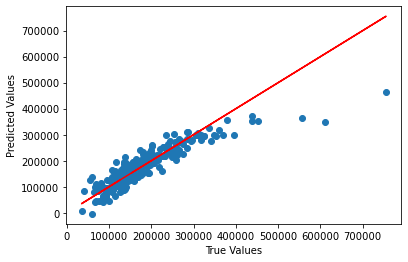

MAE: 25304.279492856378
MSE: 1504341237.99686
RMSE: 38785.83811131145
MAPE: 16.35396801485015


<IPython.core.display.Javascript object>

In [43]:
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color = 'r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('MSE: {}'.format(mse(y_test, y_pred)))
print('RMSE: {}'.format(rmse(y_test, y_pred)))
print('MAPE: {}'.format(np.mean(np.abs(((y_test-y_pred)/y_test)*100))))


In [44]:
df["totalsf"] = df["totalbsmtsf"] + df["firstflrsf"] + df["secondflrsf"]
df["inter_qual_sf"] = df["totalsf"] * df["overallqual"]

y = np.log1p(df.saleprice)
X = pd.concat([X, df["totalsf"], df["inter_qual_sf"]], axis=1)
X = X.drop(columns=["totalbsmtsf"])

<IPython.core.display.Javascript object>

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     686.5
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:06:26   Log-Likelihood:                 395.70
No. Observations:                1168   AIC:                            -775.4
Df Residuals:                    1160   BIC:                            -734.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.1380      0.060    169.316      0.000      10.021      10.256
overallqual         0.1851      0.010     19.220      0.000       0.166       0.204
grlivarea        6.524e-05   1.96e-05      3.333      0.001    2.68e-05       0.000
garagecars          0.1177      0.009     13.367      0.000       0.100       0.135
condition1_Norm     0.0631      0.015      4.263      0.000       0.034       0.092
condition2_PosN    -0.4829      0.129     -3.753      0.000      -0.735      -0.230
totalsf             0.0003   2.74e-05     11.166      0.000       0.000       0.000
inter_qual_sf   -2.371e-05   3.21e-06     -7.383      0.000      -3e-05   -1.74e-05
==============================================================================
Omnibus:                      334.236   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1954.446
Skew:                          -1.189   Prob(JB):                         0.00
Kurtosis:                       8.874   Cond. No.                     4.84e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

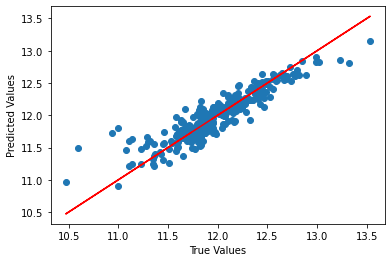

MAE: 0.12830411924850998
MSE: 0.03179558079843568
RMSE: 0.17831315374485326
MAPE: 1.0823455824120902


<IPython.core.display.Javascript object>

In [46]:
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color="r")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("MSE: {}".format(mse(y_test, y_pred)))
print("RMSE: {}".format(rmse(y_test, y_pred)))
print("MAPE: {}".format(np.mean(np.abs(((y_test - y_pred) / y_test) * 100))))

The evaluation parameters for both models show the 2nd model performance is an improvement over the 1st model.